In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer


import matplotlib.pyplot as plt
import re

from nltk.stem import WordNetLemmatizer

import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
import spacy
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

### Data Overview

This dataset contains twitter data classifying tweets into two classes based on if the tweet was about a real disaster or not. The data contains the tweet text, a single keyword summarizing the tweet, the location of the tweet, and the response field denoting if the tweet was about a real disaster or not. For this use case we will only be using the actual tweet text to make a prediction.

I will start by reading in the training data and performing some EDA and text processing before feeding data into the model

In [2]:
df_train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
df_train.sample(3)

,id,keyword,location,text,target
6850,9818,trauma,NaN,@crazyindapeg @VETS78734 completely understand...,0
339,486,armageddon,middle eastern palace,Tomorrow is the day we start armageddon #prese...,0
6469,9253,sunk,NaN,has NOT sunk in that i leave for school in a m...,0


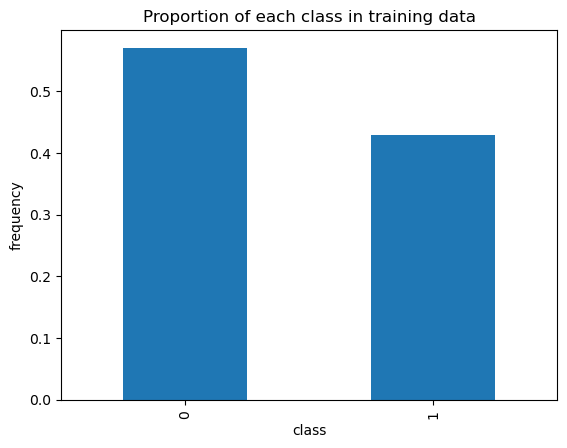

In [3]:
# get a sense of the the class balance in the training dataset. this will give us the baseline accuracy
import matplotlib.pyplot as plt

class_labels = df_train.target.value_counts(normalize=True)

plt.figure()
class_labels.plot(kind="bar")
plt.ylabel("frequency")
plt.xlabel("class")
plt.title("Proportion of each class in training data")
plt.show()

Above plot shows that ~40% of the dataset belongs to the positive class; this is a fairly balanced dataset

In [4]:
# show the number of missing records in each column;
# also this is an extremely small dataset only taking up 300 KB of memory and 7613 records, should be fairly quick modeling
df_train.info(memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


#### Processing Text Data

Before passing the text data into the neural network, we will want to perform some text cleanup so the model can ingest easier to understand tokens, restricting the amount of "noise" the model ingests. We can do this by **lowercasing** all words so they are in the same format, **removing common stopwords** that do not add much context or information to the target (such as "an", "a", "the", etc),

In [5]:
# lowercasing all the words in the text
df_train['text'] = df_train['text'].apply(lambda r: r.lower())

# remove common stopwords from the text; will get the list of stopwords from nltk library
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))

def remove_stopwords(text):
    words = text.split()
    non_stop_words = [word for word in words if word.lower() not in stop_words]
    new_text = ' '.join(non_stop_words)
    return new_text

df_train['text'] = df_train['text'].apply(lambda row: remove_stopwords(row))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# viewing some records from our cleaned dataset; everything should be lowercase and there should be no common stopwords in the text data
df_train['text'].sample(5)

1893                 wow! crushed that! #edwing #bluejays
1616    ashes 4th test: 10 hilarious twitter reactions...
6061    @moorlandschmbr loads stuff going recently. se...
2827    least 180 dead million displaced india floods ...
815                   @blizzard_draco give free art kamon
Name: text, dtype: object

Since the text data we are dealing with are tweets, and tweets tend to contain a lot of special characters such as `"#"` and `"@"`, I am going to **remove these special characters (and punctuation)** from the text

In [7]:
# removing special characters using the regex library
def remove_special_chars(text):
    dropped_hyperlinks = re.sub(r'http\S+', '', text)
    dropped_special_chars = re.sub(r'[^a-zA-Z\s]', '', dropped_hyperlinks)
    
    return dropped_special_chars

df_train['text'] = df_train['text'].apply(lambda row: remove_special_chars(row))

# again will sample some random records to view the results
df_train['text'].sample(5)

4195    dannyraynard bad personally id get rid either ...
1002    amaramin meek definitely capable body bagging ...
6919                     smoakqueen im going much trouble
1793                          let another love crash burn
5777    eric clapton shot sheriff  guess many people r...
Name: text, dtype: object

#### Tokenizing the text

before we can input text data into our model, need to format the text so the model knows each word is a separate input. This is referred to as **tokenizing** the text

In [8]:
# initialize a tokenizer with Keras since we will be using keras to build the LSTM model
# worth noting that the Tokenizer would have handled some of the preprocessing steps for us, but decided to perform separately
tokenizer = Tokenizer(num_words=10000, split=' ')

# fit tokenizer to text data
tokenizer.fit_on_texts(df_train['text'])

# convert texts to sequence of numeric tokens
tokenized_text = tokenizer.texts_to_sequences(df_train['text'])

In [9]:
# Splitting data into train / test
from tensorflow.keras.preprocessing.sequence import pad_sequences

# using pad_sequences to convert the text inputs to all have the same length. this will also reformat the text in a manner that Keras accepts 
padded_tokenized_text = pad_sequences(tokenized_text, value=0.0, maxlen=40, padding="post", truncating="post")

train_labels = np.array(df_train['target'])
X_train, X_test, y_train, y_test = train_test_split(padded_tokenized_text, train_labels, test_size=0.2, random_state=42)

### LSTM Modeling

In [10]:
# modeling libraries from tensorflow and keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, BatchNormalization, Bidirectional

In [24]:
# helper function to plot the model metrics after a training round
def plot_metrics_vs_epochs(model_hist):
    
    n_epochs = model_hist.params['epochs']
    x = [i for i in range(1,n_epochs+1)]
    train_accuracy = model_hist.history['accuracy']
    val_accuracy = model_hist.history['val_accuracy']
    
    train_loss = model_hist.history['loss']
    val_loss = model_hist.history['val_loss']
    
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    
    ax[0].plot(x, train_accuracy, label="train_acc")
    ax[0].plot(x, val_accuracy, label="val_acc", linestyle="--", color="red")
    
    ax[0].set_ylabel("accuracy")
    ax[0].set_xlabel("epochs")
    ax[0].legend()
    ax[0].set_title("Accuracy")
    
    ax[1].plot(x, train_loss, label="train_loss")
    ax[1].plot(x, val_loss, label="val_loss", linestyle="--", color="red")
    
    ax[1].set_ylabel("loss")
    ax[1].set_xlabel("epochs")
    ax[1].legend()
    ax[1].set_title("Loss")
    
    plt.show()


{'loss': [0.2501468062400818,
  0.24688751995563507,
  0.24553564190864563,
  0.24570566415786743,
  0.245638906955719,
  0.24548740684986115,
  0.24536004662513733,
  0.24531660974025726,
  0.2451700121164322,
  0.2457829713821411],
 'accuracy': [0.5534736514091492,
  0.5621148347854614,
  0.5693700313568115,
  0.5679618716239929,
  0.5679576992988586,
  0.5689696073532104,
  0.5700405836105347,
  0.5700029134750366,
  0.5710628628730774,
  0.566586434841156],
 'val_loss': [0.24467824399471283,
  0.24454757571220398,
  0.24455556273460388,
  0.2447061687707901,
  0.24458688497543335,
  0.2445637285709381,
  0.24458244442939758,
  0.24458886682987213,
  0.244565948843956,
  0.2447216808795929],
 'val_accuracy': [0.5738673806190491,
  0.5738673806190491,
  0.5738673806190491,
  0.5738673806190491,
  0.5738673806190491,
  0.5738673806190491,
  0.5738673806190491,
  0.5738673806190491,
  0.5738673806190491,
  0.5738673806190491]}

In [19]:
# create architecture of LSTM network; will keep the architecture simple for this first model and test performance
vocab_size = 10000 # hyperparameter
embeddings_dim = 200 # hyperparameter
lstm  = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embeddings_dim, input_length=40), # 40 was the value for each padded sequence length
    Bidirectional(LSTM(units=4, activation="tanh", recurrent_activation="sigmoid", return_sequences=True)),
    BatchNormalization(),
    Dropout(.25),
    Dense(units=1, activation="sigmoid")
])

n_epochs = 10
batch_size = 32
n_steps_per_epoch = batch_size * 6
lstm.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
lstm_history = lstm.fit(
    x=X_train,
    y=y_train,
    epochs=n_epochs,
    batch_size=batch_size,
    # Total number of steps (batches of samples) before declaring one epoch finished and starting the next epoch.
    steps_per_epoch=n_steps_per_epoch,
    validation_data=(X_test, y_test)
)

Epoch 1/10
192/192 [==============================] - 15s 53ms/step - loss: 0.2501 - accuracy: 0.5535 - val_loss: 0.2447 - val_accuracy: 0.5739
Epoch 2/10
192/192 [==============================] - 10s 50ms/step - loss: 0.2469 - accuracy: 0.5621 - val_loss: 0.2445 - val_accuracy: 0.5739
Epoch 3/10
192/192 [==============================] - 9s 48ms/step - loss: 0.2455 - accuracy: 0.5694 - val_loss: 0.2446 - val_accuracy: 0.5739
Epoch 4/10
192/192 [==============================] - 9s 49ms/step - loss: 0.2457 - accuracy: 0.5680 - val_loss: 0.2447 - val_accuracy: 0.5739
Epoch 5/10
192/192 [==============================] - 10s 50ms/step - loss: 0.2456 - accuracy: 0.5680 - val_loss: 0.2446 - val_accuracy: 0.5739
Epoch 6/10
192/192 [==============================] - 10s 53ms/step - loss: 0.2455 - accuracy: 0.5690 - val_loss: 0.2446 - val_accuracy: 0.5739
Epoch 7/10
192/192 [==============================] - 10s 53ms/step - loss: 0.2454 - accuracy: 0.5700 - val_loss: 0.2446 - val_accuracy: 0

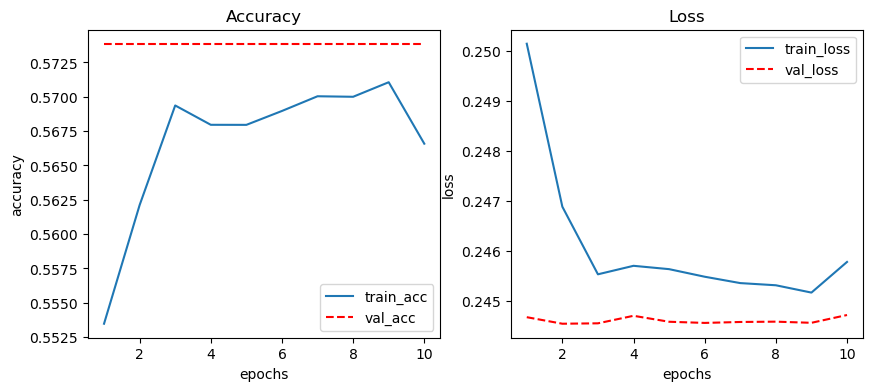

In [31]:
plot_metrics_vs_epochs(lstm_history)

The plots show above that this first model iteration performs quite poorly on both the training and the validation dataset. The validation accuracy does not fluctuate at all and remains constants at the baseline accuracy rate for the dataset, meaning that the model is not doing any real learning at all. 

I am going to make the LSTM model architecture more complex in the next iteration to try and increase performance. I am going to add a second LSTM layer, each LSTM layer will contain more cells (trying a 64 cell layer and a 32 cell layer respectively), adding a Dropout layer to avoid overfitting, and an additional Dense layer with 32 neurons prior to the final sigmoid output layer. 

In [32]:
# keeping vocab size and embeddingd dimension hyperparameters the same so i can test the effect of the LSTM architecture alone
lstm2 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embeddings_dim, input_length=40), # 40 was the value for each padded sequence length
    Bidirectional(LSTM(units=64, activation="tanh", recurrent_activation="sigmoid", return_sequences=True)),
    BatchNormalization(),
    Dropout(.25),

    Bidirectional(LSTM(units=32, activation="tanh", recurrent_activation="sigmoid", return_sequences=True)),
    BatchNormalization(),
    Dropout(.25),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

n_epochs = 20
batch_size = 32
n_steps_per_epoch = batch_size * 6
lstm2.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
lstm_history2 = lstm2.fit(
    x=X_train,
    y=y_train,
    epochs=n_epochs,
    batch_size=batch_size,
    # Total number of steps (batches of samples) before declaring one epoch finished and starting the next epoch.
    steps_per_epoch=n_steps_per_epoch
)

Epoch 1/20
192/192 [==============================] - 30s 107ms/step - loss: 0.2502 - accuracy: 0.5497
Epoch 2/20
192/192 [==============================] - 21s 108ms/step - loss: 0.2457 - accuracy: 0.5686
Epoch 3/20
192/192 [==============================] - 21s 107ms/step - loss: 0.2452 - accuracy: 0.5715
Epoch 4/20
192/192 [==============================] - 20s 105ms/step - loss: 0.2457 - accuracy: 0.5673
Epoch 5/20
192/192 [==============================] - 20s 107ms/step - loss: 0.2454 - accuracy: 0.5694
Epoch 6/20
192/192 [==============================] - 21s 108ms/step - loss: 0.2450 - accuracy: 0.5714
Epoch 7/20
192/192 [==============================] - 20s 105ms/step - loss: 0.2453 - accuracy: 0.5694
Epoch 8/20
192/192 [==============================] - 21s 107ms/step - loss: 0.2452 - accuracy: 0.5696
Epoch 9/20
192/192 [==============================] - 20s 105ms/step - loss: 0.2454 - accuracy: 0.5688
Epoch 10/20
192/192 [==============================] - 20s 104ms/step - l

The model history output shows that the above model performed similarly to the first model. Need to elaborate and change the architecture further to try and see increased performance

In [36]:
lstm3 = Sequential([
    Embedding(vocab_size, embeddings_dim, input_length=40),
    Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.5),
    
    Bidirectional(tf.keras.layers.LSTM(32)),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

n_epochs = 20
batch_size = 32
n_steps_per_epoch = batch_size * 6
lstm3.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
lstm_history3 = lstm3.fit(
    x=X_train,
    y=y_train,
    epochs=n_epochs,
    batch_size=batch_size,
    # Total number of steps (batches of samples) before declaring one epoch finished and starting the next epoch.
    steps_per_epoch=n_steps_per_epoch,
    validation_data=(X_test, y_test)
)

Epoch 1/20
192/192 [==============================] - 32s 114ms/step - loss: 0.2775 - accuracy: 0.5974 - val_loss: 0.1965 - val_accuracy: 0.6934
Epoch 2/20
192/192 [==============================] - 20s 106ms/step - loss: 0.1630 - accuracy: 0.7811 - val_loss: 0.1704 - val_accuracy: 0.7708
Epoch 3/20
192/192 [==============================] - 20s 107ms/step - loss: 0.1116 - accuracy: 0.8594 - val_loss: 0.1783 - val_accuracy: 0.7807
Epoch 4/20
192/192 [==============================] - 20s 106ms/step - loss: 0.0867 - accuracy: 0.8971 - val_loss: 0.2039 - val_accuracy: 0.7669
Epoch 5/20
192/192 [==============================] - 20s 107ms/step - loss: 0.0728 - accuracy: 0.9139 - val_loss: 0.2595 - val_accuracy: 0.6980
Epoch 6/20
192/192 [==============================] - 20s 105ms/step - loss: 0.0637 - accuracy: 0.9262 - val_loss: 0.2107 - val_accuracy: 0.7617
Epoch 7/20
192/192 [==============================] - 20s 107ms/step - loss: 0.0570 - accuracy: 0.9365 - val_loss: 0.2215 - val_ac

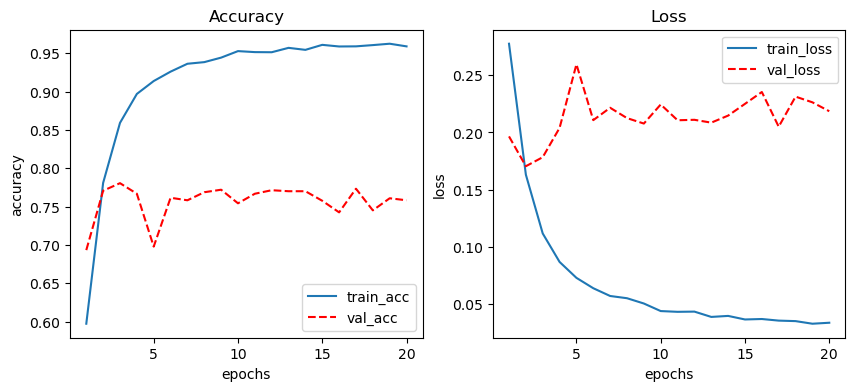

In [37]:
plot_metrics_vs_epochs(lstm_history3)

### Conclusion

As you can see from the above plots, the third model architecture performed the best on both the training and validation set. The validation accuracy seems to plateau after the 6th epoch, as does the training accuracy. So we can probably stop the model training there. The training loss and validation loss also look to plateau after the 6th epoch; staying consistent with the accuracy.

It appears that **increasing the Dropout layer** from **.25 to .5** (25% of the neurons were dropped versus 50% of the neurons were dropped) had a significant impact on model performance. The hypothesis is that the model was over fitting the training data with a Dropout layer of only .25, whereas a Dropout Layer of .5 avoided this overfitting. 

If I were to continue to test and tweak the LSTM model architecture, I could try adding a GRU layer opposed to a traditional LSTM layer and compare the performance. Additionally I could add even more GRU/LSTM layers to the model (I only tested 2 LSTM layers, could add a 3rd of 4th). 

### Making predictions on test dataset and saving submit to competition

In [38]:
df_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

In [39]:
# will perform the same processing on the test data that was performed on the training data
df_test['text'] = df_test['text'].apply(lambda r: r.lower())
df_test['text'] = df_test['text'].apply(lambda row: remove_stopwords(row))
df_test['text'] = df_test['text'].apply(lambda row: remove_special_chars(row))

tokenizer = Tokenizer(num_words=10000, split=' ')

# fit tokenizer to text data
tokenizer.fit_on_texts(df_test['text'])

# convert texts to sequence of numeric tokens
tokenized_test_text = tokenizer.texts_to_sequences(df_test['text'])
padded_tokenized_test_text = pad_sequences(tokenized_test_text, value=0.0, maxlen=40, padding="post", truncating="post")

In [42]:
test_preds = lstm3.predict(padded_tokenized_test_text)
test_preds = np.round(test_preds).astype(int).flatten()

In [46]:
df_test['target'] = test_preds
df_test[["id", "target"]].to_csv("lstm3_test_preds.csv", index=False)